In [2]:
import numpy as np
import torch

In [3]:
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import torchvision.transforms.functional as F

dtype = torch.float32

In [4]:
def plot_dist(w1, w2):
    w1_flat = w1.flatten().detach().numpy()
    w2_flat = w2.flatten().detach().numpy()

    # Plot the histograms
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(w1_flat, bins=50)
    plt.title('Distribution of initial weights of w1')
    plt.xlabel('Weight value')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(w2_flat, bins=50)
    plt.title('Distribution of initial weights of w2')
    plt.xlabel('Weight value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [5]:
batch_size = 64

mnist_train = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000)))

mnist_val = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000, 60000)))

torch.Size([64, 1, 28, 28])


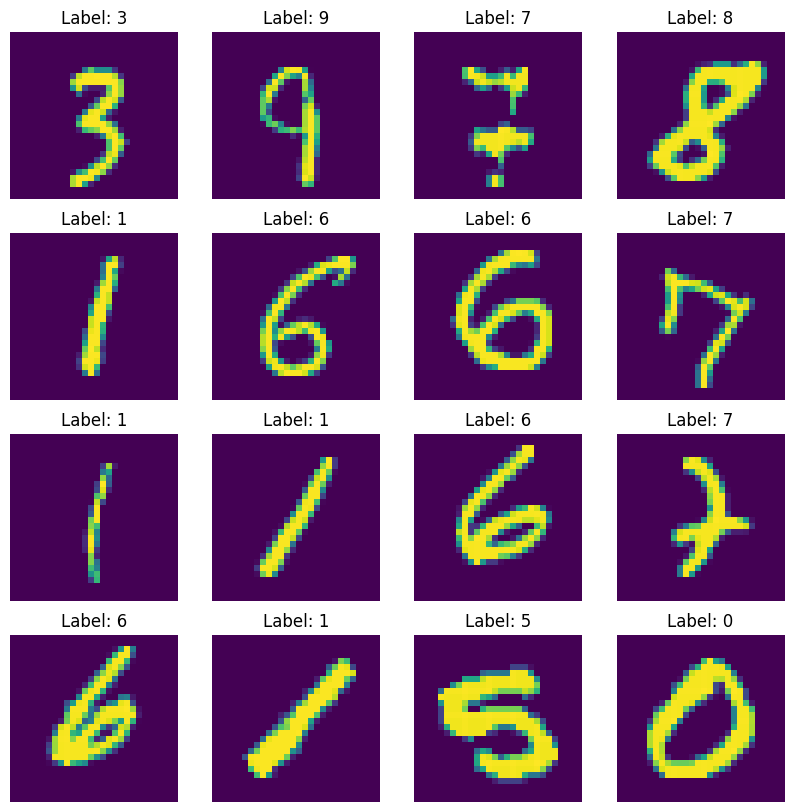

In [6]:
images, labels = next(iter(loader_train))

# Print the shape of the images and labels
print(images.shape)

# Plot the images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(f"Label: {labels[i]}")

plt.show()


In [7]:
def two_layer_fc(x, params):
    x = x.view(-1, 28 * 28)
    w1, w2 = params

    x = torch.relu(x @ w1)
    x = x @ w2
    
    return x


# Example usage:
dtype = torch.float
batch_size = 64  # Assuming a batch size is defined somewhere.

x = torch.zeros((batch_size, 28 * 28), dtype=dtype)
hidden_layer_size = 42

w1 = torch.zeros((28 * 28, hidden_layer_size), dtype=dtype, requires_grad=True)
w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype, requires_grad=True)

scores = two_layer_fc(x, [w1, w2])

In [8]:
def random_weight(shape):
    if len(shape) == 2:
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:])
    
    w = torch.randn(shape, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    
    return w

def zero_weight(shape):
    return torch.zeros(shape, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU.
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[-0.8984,  0.9510,  1.3804,  0.4352,  0.3240],
        [ 0.0926,  1.2341,  0.4919, -0.7516,  0.4005],
        [ 0.2977,  0.4957,  1.1462,  0.1331,  0.4623]], requires_grad=True)

In [9]:
def check_accuracy(loader, model_fn, params):
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
        
        return acc

In [10]:
def train(model_fn, params, learning_rate, locs, print_every=100):
    w1, w2 = params
    
    last_accuracy = 0   
    
    overtime = [[] for _ in range(len(locs))]
    
    for t, (x, y) in enumerate(loader_train):
            
        scores = model_fn(x, [w1, w2])
        loss = torch.nn.functional.cross_entropy(scores, y)
        loss.backward()
        
        with torch.no_grad():
            
            w1 -= learning_rate * w1.grad
            w2 -= learning_rate * w2.grad

            w1.grad.zero_()
            w2.grad.zero_()
            
        for i in range(len(locs)):
            overtime[i].append(w1[locs[i][0]][locs[i][1]].item())

        if t % print_every == 0:            
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            
            last_accuracy = check_accuracy(loader_val, model_fn, [w1, w2])

    return overtime

In [11]:
hidden_layer_size = 40
learning_rate = 1e-2

w1 = random_weight((28 * 28, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

In [14]:
import random
hidden_layer_size = 200
learning_rate = 1e-2 * 2

w1 = random_weight((28 * 28, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))


m1 = torch.ones((28 * 28, hidden_layer_size), dtype=dtype)
m2 = torch.ones((hidden_layer_size, 10), dtype=dtype)

# Get the shape of w1
rows, cols = w1.shape

# Generate a list of unique random tuples
locations = []
while len(locations) < 10:
    row = random.randint(0, rows - 1)
    col = random.randint(0, cols - 1)
    location = (row, col)
    if location not in locations:
        locations.append(location)

# print(locations)

res = train(two_layer_fc, [w1, w2], learning_rate, locations, print_every=200)

print(w1[0:10])

Iteration 0, loss = 2.4187
Checking accuracy on the val set
Got 566 / 10000 correct (5.66%)
Iteration 200, loss = 0.6095
Checking accuracy on the val set
Got 8575 / 10000 correct (85.75%)
Iteration 400, loss = 0.6179
Checking accuracy on the val set
Got 8867 / 10000 correct (88.67%)
Iteration 600, loss = 0.3655
Checking accuracy on the val set
Got 8971 / 10000 correct (89.71%)
tensor([[ 0.0254,  0.0231, -0.0127,  ..., -0.0539,  0.0289, -0.0242],
        [-0.0023,  0.0187, -0.1273,  ..., -0.0056, -0.0153, -0.0253],
        [-0.0156,  0.0196,  0.1059,  ...,  0.0410,  0.0360, -0.0245],
        ...,
        [-0.0436, -0.0615,  0.0034,  ..., -0.0025,  0.0518, -0.0470],
        [ 0.0360,  0.0462, -0.0021,  ..., -0.0517, -0.0292,  0.0613],
        [ 0.0530,  0.0396, -0.0314,  ..., -0.0839, -0.0422, -0.0019]],
       grad_fn=<SliceBackward0>)


[(581, 145), (652, 76), (411, 68), (171, 48), (272, 155), (27, 60), (396, 136), (774, 171), (218, 32), (677, 170)]


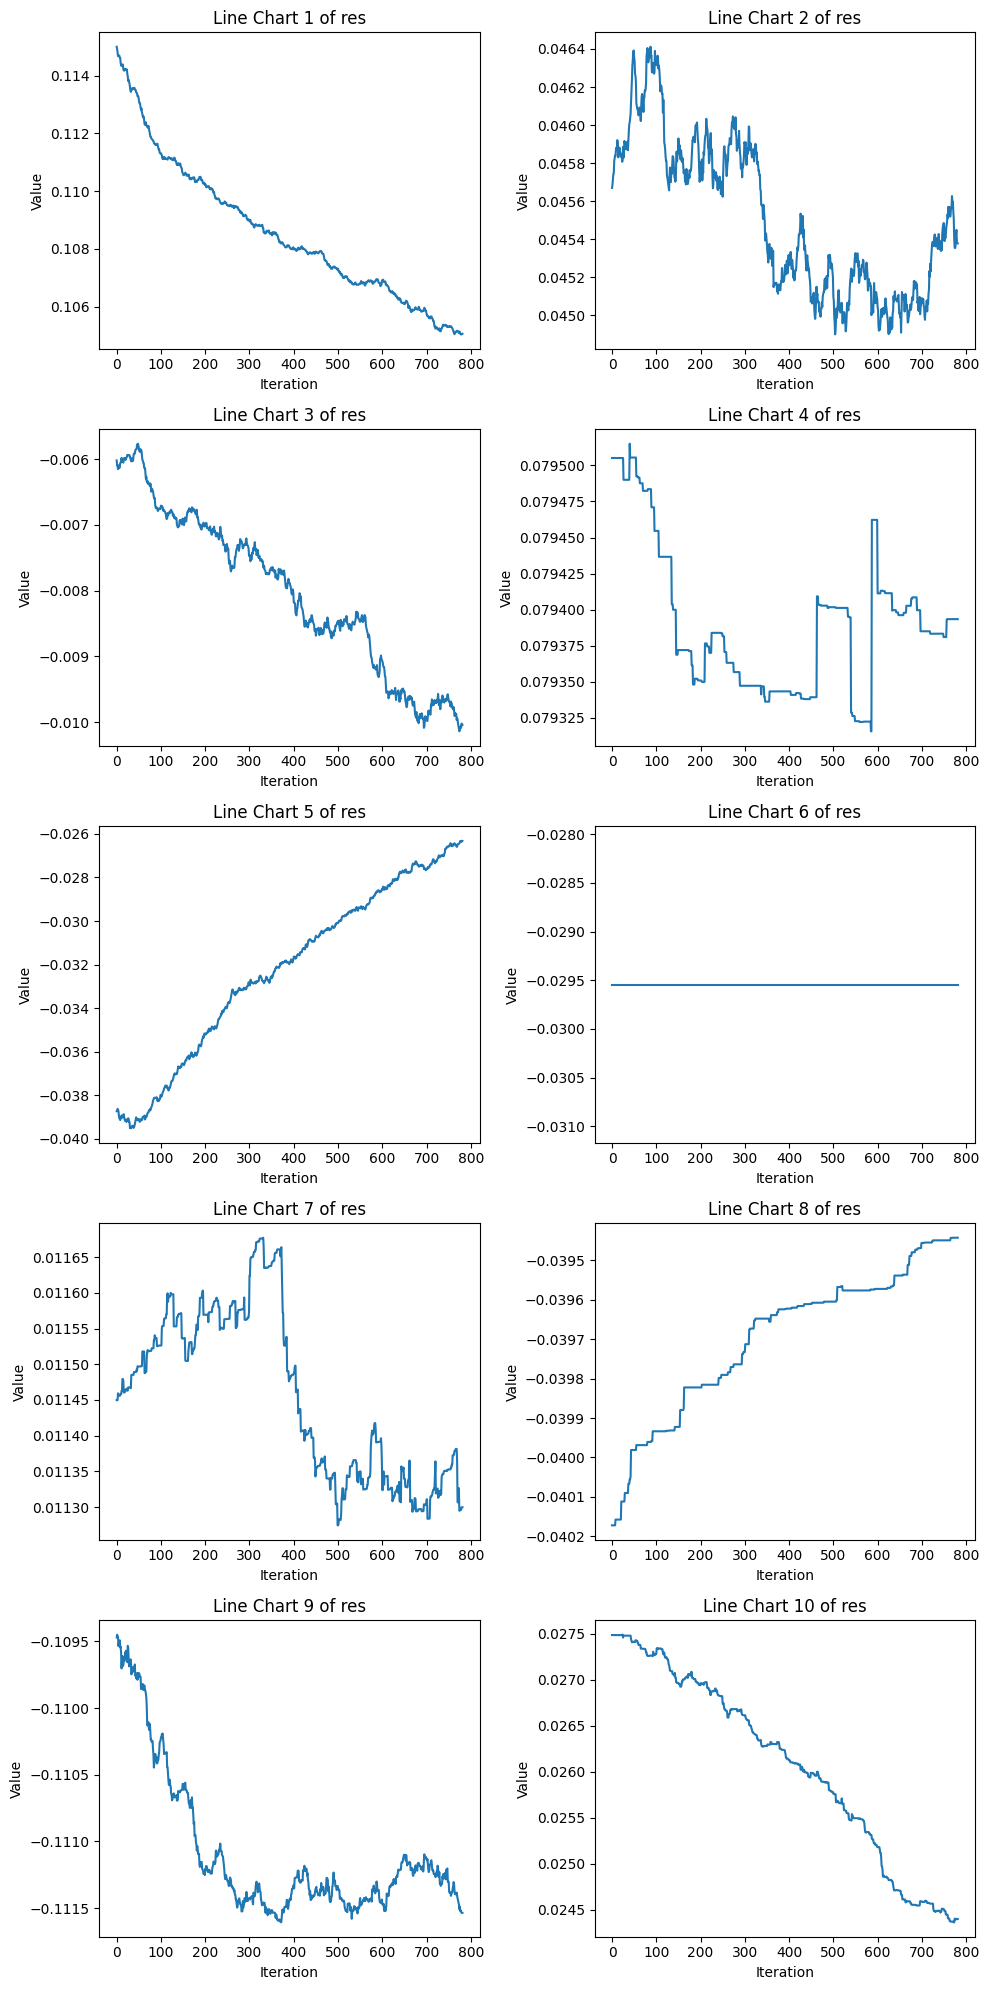

In [15]:
print(locations)

fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for i, ax in enumerate(axes.flat):
    ax.plot(res[i])
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Value')
    ax.set_title(f'Line Chart {i+1} of res')

plt.tight_layout()
plt.show()
